In [1]:
# если выдает ошибку с пакетами
# установить пакеты и перезапустить ядро
# TODO: сделать установку окружений

# !pip install scikit-learn --force
# !pip install catboost
# !pip install sktime==0.15.1
# !pip install pandas==1.3.5

In [2]:
import sys
sys.path.append('../..')
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd
from datetime import datetime
import os
import importlib

pd.set_option('display.max.columns', 300)

from core.calculator.storage import ModelDB
from core.calculator.core import ForecastConfig
from core.calculator.core import TrainingManager
from core.calculator.core import ForecastConfig
from core.calculator.core import ForecastEngine

from core.calculator.deposits import DepositsCalculationType
from core.calculator.deposits import DepositIterativeCalculator

from core.definitions import *
from core.project_update import load_portfolio

from core.models import DepositModels
from warnings import filterwarnings
filterwarnings('ignore')

## Подгрузка сценария

Нам необходимо сделать прогноз баланса для Казначейства. С этого месяца прогнозы для Казначейства станут ежемесячными.  
Необходимо сделать прогноз  от 31 мая на 7 месяцев.  

Данные по прогнозу макро показателей в приложении (лист «Макро от 21_05_Основные», строки 20-21, либо ставки и индикаторы «Ставки_New»). Изменения затронули КС, текущий прогноз – 16,00% до конца года.  
Опционы и надбавки остаются прежними, данные по прогнозу ТС коллеги обещали скинуть в ближайшее время.  

## Постановка задачи

Я правильно понял, что в калькулятор передаётся сетка по марже? Давай попробуем для каждого продукта и сегмента сдвинуть кривую маржи на +10, +20, -10, -20 бп. Тогда получится 6*3*5=90 (вклады) + 15 (НС) сценариев.


In [3]:
# spark

In [4]:
# df1 = spark.table('prod_dadm_alm_sbx.almde_fl_dpst_scenario')

In [5]:
# df2 = df1.toPandas()

In [6]:
# df2.tail()

In [7]:
# df2.to_csv('scenario.csv')

### Подготовка сценария

In [8]:
# Дата из который мы прогнозируем
train_end = datetime(year=2024, month=5, day=31)

# Горизонт прогноза в месяцах
horizon = 7

In [9]:
# Данные для прогноза
scenario_data = {
    # Ожидаемый баланс на первую дату прогноза, задавать необязательно
     'expected_amount':      [np.nan for h in range(horizon)],
    # ССВ
     'SSV':                  [0.48 for h in range(horizon)],
    # ФОР
     'FOR':                  [4.5 for h in range(horizon)],
    # Трансфертные ставки
     'VTB_ftp_rate_[90d]':   [12.3 for h in range(horizon)],
     'VTB_ftp_rate_[180d]':  [12 for h in range(horizon)],
     'VTB_ftp_rate_[365d]':  [12 for h in range(horizon)],
     'VTB_ftp_rate_[548d]':  [12 for h in range(horizon)],
     'VTB_ftp_rate_[730d]':  [12 for h in range(horizon)],
     'VTB_ftp_rate_[1095d]': [12 for h in range(horizon)],
    
    # Маржа бизнеса по срочностям
     'margin_[90d]':         [0.1 for h in range(horizon)],
     'margin_[180d]':        [0.1 for h in range(horizon)],
     'margin_[365d]':        [0.1 for h in range(horizon)],
     'margin_[548d]':        [0.1 for h in range(horizon)],
     'margin_[730d]':        [0.2 for h in range(horizon)],
     'margin_[1095d]':       [0.2 for h in range(horizon)],
    
    # Спред Привилегия - Массовый (на сколько в среднем ставки по сегменту Привилегия больше чем ставки по массовому сегменту)
     'priv_spread':          [0.4 for h in range(horizon)],
    # Спред ВИП - Массовый (на сколько в среднем ставки по сегменту ВИП больше чем ставки по массовому сегменту)
     'vip_spread':           [0.8 for h in range(horizon)],
    
    # Ниже три спреда по разным типам опциональности по отношению к безопциональным вкладам (Подразумевается, что они, как правило, отрицательные)
    # r - возможности пополнения, s - возможность расходных операций
    
    # На сколько ставка по расходным вкладам выше чем ставка по безопциональным вкладам (Если ниже - то со знаком минус)
     'r0s1_spread':          [-1 for h in range(horizon)],
    
    # На сколько ставка по пополняемым вкладам выше чем ставка по безопциональным вкладам (Если ниже - то со знаком минус)
     'r1s0_spread':          [-1 for h in range(horizon)],
    
    # На сколько ставка по расходно-пополняемым вкладам выше чем ставка по безопциональным вкладам (Если ниже - то со знаком минус)
     'r1s1_spread':          [-1.2 for h in range(horizon)],
    
    # Ставка по лучшему предложению сбера
     'SBER_max_rate':        [11.2 for h in range(horizon)],
    
    # Базовая ставка по НС
     'SA_rate':              [5 for h in range(horizon)]
}
scenario_df_user = pd.DataFrame(scenario_data)

In [10]:
scenario_df = preprocess_scenario(scenario_df_user, train_end, horizon)

## Готовим сценарий

In [11]:
sc_new = pd.read_csv('scenario.csv', index_col='Unnamed: 0')

In [12]:
sc_new = sc_new.tail().iloc[-1]

In [13]:
sc_new['VTB_ftp_rate_[90d]']

17.1

In [14]:
for col in scenario_df.columns:
    
    try:
        scenario_df[col] = sc_new[col]
        
    except KeyError:
        scenario_df[col] = np.nan

In [15]:
scenario_df['SBER_max_rate'] = 16

### Коррекция на обновленные FTP ставки

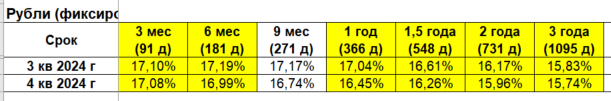

Ищем 

In [16]:
d = {'VTB_ftp_rate_[90d]': [17.1, 17.1, 17.1, 17.1, 17.08, 17.08, 17.08], 
     'VTB_ftp_rate_[180d]': [17.19, 17.19, 17.19, 17.19, 16.99, 16.99, 16.99],
     'VTB_ftp_rate_[365d]': [17.04, 17.04, 17.04, 17.04, 16.45, 16.45, 16.45],
     'VTB_ftp_rate_[548d]': [16.61, 16.61, 16.61, 16.61, 16.26, 16.26, 16.26],
     'VTB_ftp_rate_[730d]': [16.17, 16.17, 16.17, 16.17, 15.96, 15.96, 15.96],
     'VTB_ftp_rate_[1095d]': [15.83, 15.83, 15.83, 15.83, 15.83, 15.83, 15.83]
    }

ftp_new = pd.DataFrame(data=d)
ftp_new.index = scenario_df.index

In [19]:
coefs = ftp_new / scenario_df[ftp_new.columns]

In [20]:
coefs.columns = ['90d', '180d', '365d', '548d', '730d', '1095d']

In [22]:
for coef_col in coefs.columns:
    for sc_col in scenario_df.columns:
        
        if coef_col in sc_col:
            scenario_df[sc_col] = scenario_df[sc_col] * coefs[coef_col]

In [24]:
scenario_df = scenario_df.fillna(0.01)

In [25]:
scenario_df['expected_amount'] = np.nan

## Задаем оптимизатор для маржи

In [29]:
import random

In [35]:
def random_search(num_iterations):
    
    d = {}
    
    segments = ['mass', 'priv', 'vip']
    options = ['r0s0', 'r1s0', 'r1s1']
    rates = [-2, 2]
    
    # генерируем пары сегмент-опция
    
    for iteration in range(num_iterations):
        d_res = {}
        for segm in segments:
            for opt in options:
                
                name = segm + '_' + opt
                rate = random.uniform(rates[0], rates[1])
                
                d_res[name] = rate
                
        d[iteration+1] = d_res
        
        
    return d

In [47]:
def change_scenario(orig_sc, change_dict):
    
    """
    Добавляем один сценарий - на выходе один сценарий, чтобы не было утечки памяти. 
    Далее - итерируем.
    """
    
    fix_sc = orig_sc.copy()
    
    for key in change_dict.keys():
        
        segm = key.split('_')[0]
        opt = key.split('_')[1]
        
        diff_rate = change_dict[key]
        
        for col in fix_sc.columns:
            if ((segm in col)&(opt in col)):
                fix_sc[col] =  fix_sc[col] + diff_rate
    
    return fix_sc

### Чтение портфеля и моделей

In [51]:
port_folder = '../../data'
portfolio = load_portfolio(train_end, port_folder)

In [52]:
# если хотим обучить модели - инициализировать спарк

from core.models.utils import run_spark_session
#spark = run_spark_session('check_calc')

# spark = None #если без обучения

In [54]:
folder = '../data/trained_models'
folder = '/home/vtb70186744/volumes/nfs_ssdp_upfm/modeldb_submodule'

sqlite_filepath = os.path.join(folder, 'modeldb_test.bin')

DB_URL = f"sqlite:///{sqlite_filepath}"
model_db = ModelDB(DB_URL)

In [55]:
# важная ячейка, необходимая для обучения моделей orbit

ENV_NAME = 'hmelevskoi_env'

os.environ['CC'] = 'x86_64-conda-linux-gnu-gcc'
os.environ['CXX'] = 'x86_64-conda-linux-gnu-g++'
os.environ['PATH'] = os.path.abspath(f'/tmp/envs/{ENV_NAME}/bin') + ':' + os.environ['PATH']

### Старт расчетов

Обернем в цикл

In [ ]:
# число сценариев
num_scenarios = 5
scenarios_dict = random_search(num_scenarios)


for key_sc in scenarios_dict.keys():
    
    print(key_sc)

    # сценарии с учетом замены
    sc_new = change_scenario(scenario_df, scenarios_dict[key_sc])
    
    
    config: ForecastConfig = ForecastConfig(
        first_train_end_dt = train_end,
        horizon = horizon,
        trainers = DepositModels.trainers,
        data_loaders = DepositModels.dataloaders,
        calculator_type = DepositIterativeCalculator,
        calc_type = DepositsCalculationType,
        adapter_types = DepositModels.adapter_types,
        scenario_data = sc_new,
        portfolio = portfolio
    )

    training_manager = TrainingManager(spark, config.trainers, folder, model_db)   
    engine: ForecastEngine = ForecastEngine(spark, config, training_manager, overwrite_models=False)



    engine.run_all()


    portfolio_res = engine.calc_results['Deposits']['portfolio'] 
    agg_res = engine.calc_results['Deposits']['agg_data']
    
    # sc_new
    
    # сохраняем сценарии
    
    path = '/home/vtb70186744/volumes/nfs_ssdp_upfm/dynbalance_optimyzer_res/'
    
    sc_new.to_csv(path+f'scenario/scenario_{key_sc}.csv', index=True)
    agg_res.to_csv(path+f'agg_res/agg_res_{key_sc}.csv', index=True)
    portfolio_res.to_csv(path+f'portfolio_res/portfolio_res_{key_sc}.csv', index=True)
    
    

1


INFO:core:missing models: []
INFO:core:add_models_from_bytes
INFO:core:plan_close_201402_202405 - adapter <class 'core.models.plan_close.plan_close_model.PlanCloseModelAdapter'>
INFO:core:renewal_model_201401_202405 - adapter <class 'core.models.renewal.renewal_model.RenewalModelAdapter'>
INFO:core:maturity_structure_mass_r0s0_201401_202405 - adapter <class 'core.models.newbusiness.maturity_structure.maturity_structure_mass_model.MaturityStructureMassR0S0ModelAdapter'>
INFO:core:maturity_structure_mass_r0s1_202001_202405 - adapter <class 'core.models.newbusiness.maturity_structure.maturity_structure_mass_model.MaturityStructureMassR0S1ModelAdapter'>
INFO:core:maturity_structure_mass_r1s0_201401_202405 - adapter <class 'core.models.newbusiness.maturity_structure.maturity_structure_mass_model.MaturityStructureMassR1S0ModelAdapter'>
INFO:core:maturity_structure_mass_r1s1_201401_202405 - adapter <class 'core.models.newbusiness.maturity_structure.maturity_structure_mass_model.MaturityStruct

2


INFO:core:missing models: []
INFO:core:add_models_from_bytes
INFO:core:plan_close_201402_202405 - adapter <class 'core.models.plan_close.plan_close_model.PlanCloseModelAdapter'>
INFO:core:renewal_model_201401_202405 - adapter <class 'core.models.renewal.renewal_model.RenewalModelAdapter'>
INFO:core:maturity_structure_mass_r0s0_201401_202405 - adapter <class 'core.models.newbusiness.maturity_structure.maturity_structure_mass_model.MaturityStructureMassR0S0ModelAdapter'>
INFO:core:maturity_structure_mass_r0s1_202001_202405 - adapter <class 'core.models.newbusiness.maturity_structure.maturity_structure_mass_model.MaturityStructureMassR0S1ModelAdapter'>
INFO:core:maturity_structure_mass_r1s0_201401_202405 - adapter <class 'core.models.newbusiness.maturity_structure.maturity_structure_mass_model.MaturityStructureMassR1S0ModelAdapter'>
INFO:core:maturity_structure_mass_r1s1_201401_202405 - adapter <class 'core.models.newbusiness.maturity_structure.maturity_structure_mass_model.MaturityStruct

3


INFO:core:add_models_from_bytes
INFO:core:plan_close_201402_202405 - adapter <class 'core.models.plan_close.plan_close_model.PlanCloseModelAdapter'>
INFO:core:renewal_model_201401_202405 - adapter <class 'core.models.renewal.renewal_model.RenewalModelAdapter'>
INFO:core:maturity_structure_mass_r0s0_201401_202405 - adapter <class 'core.models.newbusiness.maturity_structure.maturity_structure_mass_model.MaturityStructureMassR0S0ModelAdapter'>
INFO:core:maturity_structure_mass_r0s1_202001_202405 - adapter <class 'core.models.newbusiness.maturity_structure.maturity_structure_mass_model.MaturityStructureMassR0S1ModelAdapter'>
INFO:core:maturity_structure_mass_r1s0_201401_202405 - adapter <class 'core.models.newbusiness.maturity_structure.maturity_structure_mass_model.MaturityStructureMassR1S0ModelAdapter'>
INFO:core:maturity_structure_mass_r1s1_201401_202405 - adapter <class 'core.models.newbusiness.maturity_structure.maturity_structure_mass_model.MaturityStructureMassR1S1ModelAdapter'>
INF

4


INFO:core:add_models_from_bytes
INFO:core:plan_close_201402_202405 - adapter <class 'core.models.plan_close.plan_close_model.PlanCloseModelAdapter'>
INFO:core:renewal_model_201401_202405 - adapter <class 'core.models.renewal.renewal_model.RenewalModelAdapter'>
INFO:core:maturity_structure_mass_r0s0_201401_202405 - adapter <class 'core.models.newbusiness.maturity_structure.maturity_structure_mass_model.MaturityStructureMassR0S0ModelAdapter'>
INFO:core:maturity_structure_mass_r0s1_202001_202405 - adapter <class 'core.models.newbusiness.maturity_structure.maturity_structure_mass_model.MaturityStructureMassR0S1ModelAdapter'>
INFO:core:maturity_structure_mass_r1s0_201401_202405 - adapter <class 'core.models.newbusiness.maturity_structure.maturity_structure_mass_model.MaturityStructureMassR1S0ModelAdapter'>
INFO:core:maturity_structure_mass_r1s1_201401_202405 - adapter <class 'core.models.newbusiness.maturity_structure.maturity_structure_mass_model.MaturityStructureMassR1S1ModelAdapter'>
INF

5


INFO:core:missing models: []
INFO:core:add_models_from_bytes
INFO:core:plan_close_201402_202405 - adapter <class 'core.models.plan_close.plan_close_model.PlanCloseModelAdapter'>
INFO:core:renewal_model_201401_202405 - adapter <class 'core.models.renewal.renewal_model.RenewalModelAdapter'>
INFO:core:maturity_structure_mass_r0s0_201401_202405 - adapter <class 'core.models.newbusiness.maturity_structure.maturity_structure_mass_model.MaturityStructureMassR0S0ModelAdapter'>
INFO:core:maturity_structure_mass_r0s1_202001_202405 - adapter <class 'core.models.newbusiness.maturity_structure.maturity_structure_mass_model.MaturityStructureMassR0S1ModelAdapter'>
INFO:core:maturity_structure_mass_r1s0_201401_202405 - adapter <class 'core.models.newbusiness.maturity_structure.maturity_structure_mass_model.MaturityStructureMassR1S0ModelAdapter'>
INFO:core:maturity_structure_mass_r1s1_201401_202405 - adapter <class 'core.models.newbusiness.maturity_structure.maturity_structure_mass_model.MaturityStruct